# Imports

In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import keras
import tensorflow as tf
from keras import layers
import numpy as np
from keras import backend as K
import os
import cv2
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras

# Loading Data

In [2]:
def load_images_from_folder(folder,samples):
    images = []
    count = 0
    for filename in os.listdir(folder):
        if count < samples:
            count +=1
            img = cv2.imread(os.path.join(folder,filename))
            img=cv2.resize(img,(64,64))
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                images.append(img)
    return images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/cat_faces"

Mounted at /content/drive


In [4]:
X = load_images_from_folder(path,60)
len(X)

60

In [5]:
x_train = np.array(X)


In [6]:
x_train = x_train.astype('float32') / 255.0


# Sample of the Data

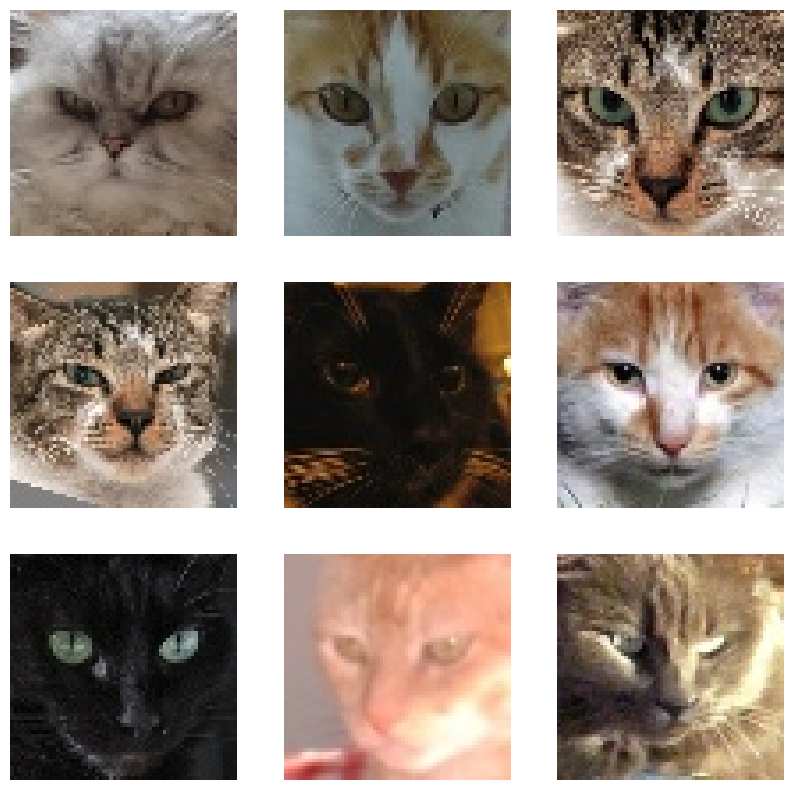

In [7]:
plt.figure(figsize=(10, 10))
# for images in x_train.shape[0]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")

In [8]:
latent_dim = 4
input_img = keras.Input(shape=(64, 64, 3))

## encoder

In [9]:
x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(input_img)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)


x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)


x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)


x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

In [10]:
shape = K.int_shape(x)
shape

(None, 16, 16, 64)

## latent vector

In [11]:
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean', kernel_initializer="zeros", bias_initializer="zeros")(x)
z_log_sigma = Dense(latent_dim, name='z_log_sigma', kernel_initializer="zeros", bias_initializer="zeros")(x)

In [12]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])



In [13]:
encoder = Model(input_img, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 bn_1 (BatchNormalization)      (None, 64, 64, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 64, 64, 32)   0           ['bn_1[0][0]']                   
                                                                                            

## going up with the dimensions and building the decoder

In [14]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3],
          activation='relu')(latent_inputs)

print(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 16384), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")


In [15]:
x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)

# Block-3
x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
outputs = layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)

In [16]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             81920     
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [17]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 4),               16880584  
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         175747    
                                                                 
Total params: 17,056,331
Trainable params: 17,055,563
Non-trainable params: 768
_________________________________________________________________


In [18]:
reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(input_img-outputs), axis=[1, 2, 3])
reconstruction_loss *= 1000
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00025),metrics=['accuracy'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          16880584    ['input_1[0][0]']                
                                 (None, 4),                                                       
                                 (None, 4)]                                                       
                                                                                                  
 decoder (Functional)           (None, 64, 64, 3)    175747      ['encoder[0][2]']                
                                                                                                

In [19]:
vae.fit(x_train, x_train,epochs=150,batch_size=1)

Epoch 1/150
60/60 [==============================] - 23s 13ms/step - loss: 85.4170 - accuracy: 0.4144
Epoch 2/150
60/60 [==============================] - 1s 13ms/step - loss: 71.8731 - accuracy: 0.5996
Epoch 3/150
60/60 [==============================] - 1s 13ms/step - loss: 69.7177 - accuracy: 0.6520
Epoch 4/150
60/60 [==============================] - 1s 13ms/step - loss: 67.7343 - accuracy: 0.7149
Epoch 5/150
60/60 [==============================] - 1s 14ms/step - loss: 65.1178 - accuracy: 0.7074
Epoch 6/150
60/60 [==============================] - 1s 13ms/step - loss: 64.4371 - accuracy: 0.7399
Epoch 7/150
60/60 [==============================] - 1s 13ms/step - loss: 62.1029 - accuracy: 0.7480
Epoch 8/150
60/60 [==============================] - 1s 16ms/step - loss: 60.2124 - accuracy: 0.7590
Epoch 9/150
60/60 [==============================] - 1s 17ms/step - loss: 58.1260 - accuracy: 0.7383
Epoch 10/150
60/60 [==============================] - 1s 18ms/step - loss: 54.4272 - accur

In [20]:
decoder.save_weights('dec_last.h5')

In [21]:
decoder.load_weights('dec_last.h5')

1/1 [==============================] - 0s 390ms/step


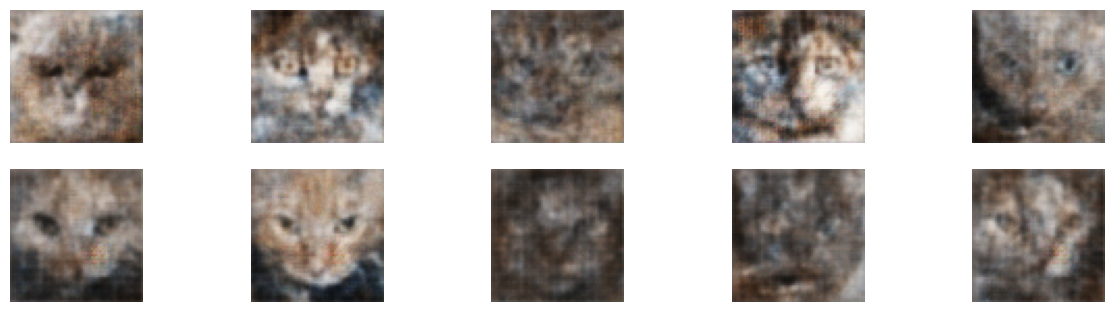

In [22]:
figsize = 15

x = np.random.normal(size = (10,4))
#x = np.random.uniform(size = (10,200))
reconstruct = decoder.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

In [23]:
def generate(num_of_images):


  x = np.random.normal(size = (num_of_images,latent_dim))
  reconstruct = decoder.predict(x)
  for img in reconstruct:
    plt.imshow(img)
    plt.show()


## GUI implementation


IntSlider(value=1, description='Slider:', max=12, min=1)

1/1 [==============================] - 0s 130ms/step


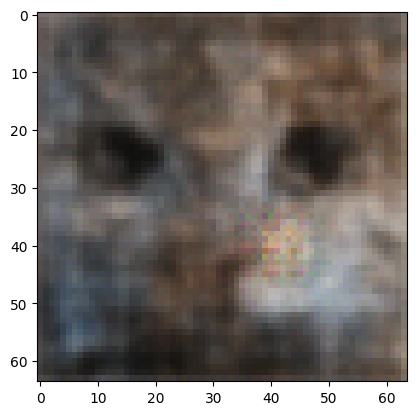

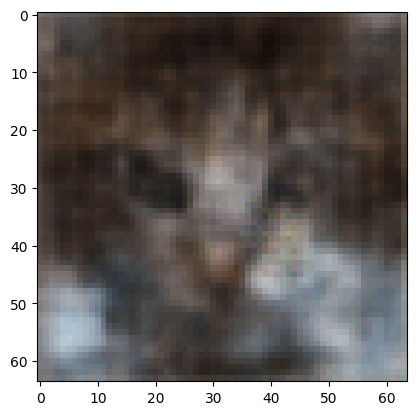

None

1/1 [==============================] - 0s 118ms/step


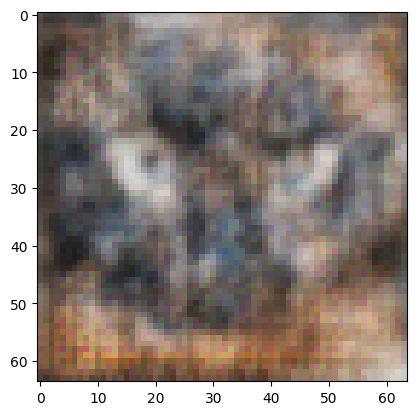

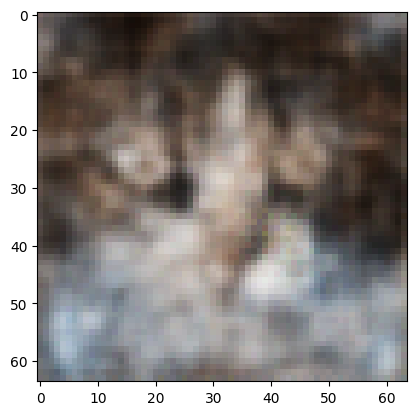

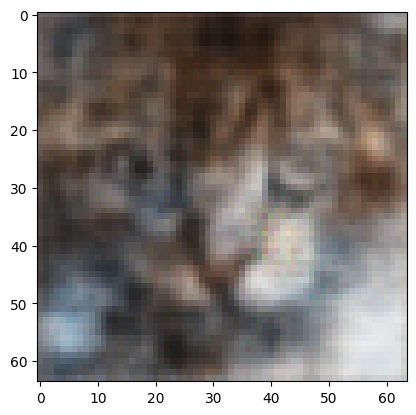

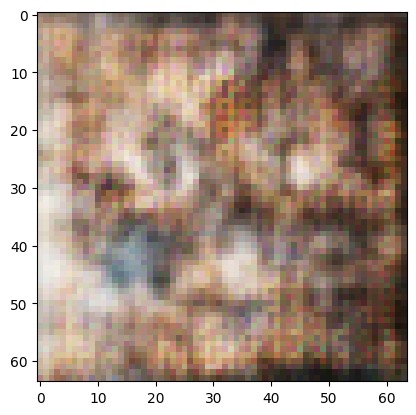

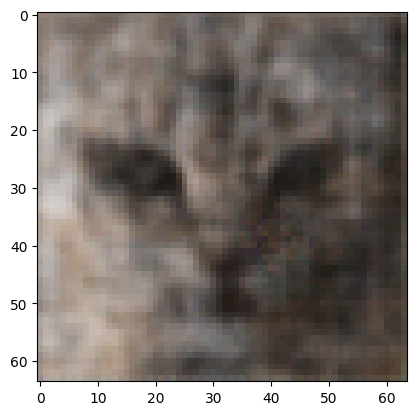

None

In [24]:
import random
import ipywidgets as widgets
from IPython.display import clear_output


# Create the slider
slider = widgets.IntSlider(min=1, max=12, value=1, description='Slider:')

# Display the slider
display(slider)

# Define a function that generates and displays random numbers when the slider value changes
def on_value_change(change):

    result = generate(change.new)
    display(result)

# Bind the "on_value_change" function to the "observe" method of the slider
slider.observe(on_value_change, names='value')
